<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/Phase2/9.%20T3D/T3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementing T3D

In this file, all the steps in T3D code are explained in detail

In [0]:
!pip install pybullet

     |████████████████████████████████| 95.0MB 46kB/s 


# Step 1: Initialization, Importing all necessary libraries

In [0]:
#Implementing T3D

#Initialization
import os
import time
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pybullet_envs
import gym
from gym import wrappers
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# Step 2: Initialize the Replay memory

Initialize the Experience Replay memory. This will store the past transitions from which it learns the Q-values.
Each transition is composed of  - the current state(S), the next state(S'), the action(a), and the reward(r).

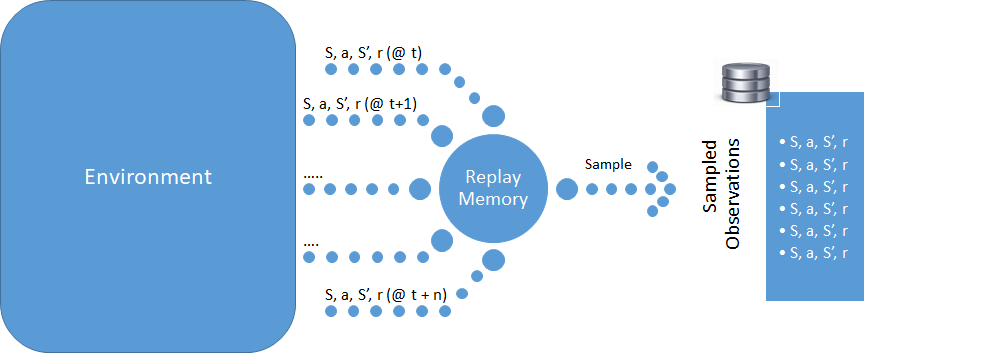

In [0]:
class ReplayBuffer(object):
    """Buffer to store tuples of experience replay"""
    
    def __init__(self, max_size=1e6):
        """
        Args:
            max_size (int): total amount of tuples to store
        """
        
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, transition):
        """Add experience tuples to buffer
        
        Args:
            transition (tuple): experience replay tuple
        """
        
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = transition
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(transition)

    def sample(self, batch_size):
        """Samples a random amount of experiences from buffer of batch size
        
        Args:
            batch_size (int): size of sample
        """
        
        ind = np.random.randint(0, len(self.storage), batch_size)
        batch_states, batch_actions, batch_next_states, batch_rewards, batch_dones = [], [], [], [], []

        for i in ind: 
            state, action, next_state, reward, done = self.storage[i]
            batch_states.append(np.array(state, copy=False))
            batch_actions.append(np.array(action, copy=False))
            batch_next_states.append(np.array(next_state, copy=False))
            batch_rewards.append(np.array(reward, copy=False))
            batch_dones.append(np.array(done, copy=False))

        return np.array(batch_states), np.array(batch_actions), np.array(batch_next_states), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

#Step 3: Build one DNN for both Actor target and Actor Model

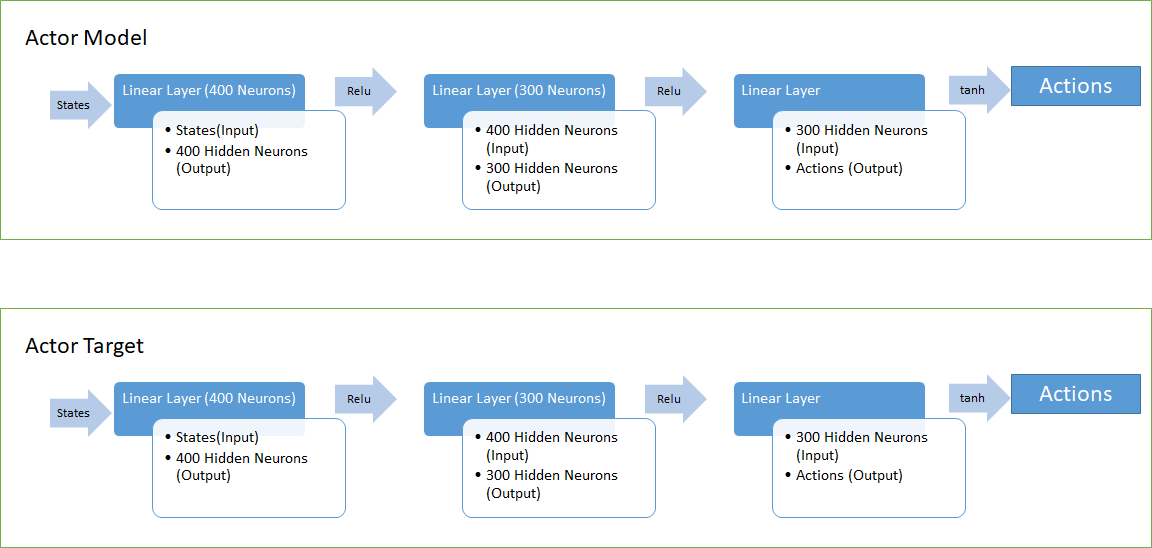

In [0]:
class Actor(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            action output of network with tanh activation
    """
    
    def __init__(self, state_dims, action_dim, max_action):
        super(Actor, self).__init__()

        self.layer_1 = nn.Linear(state_dims, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, action_dim)

        self.max_action = max_action


    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.layer_3(x)) 
        return x



### Build two DNNs for the two Critic models and two DNNs for the two Critic Targets

In [0]:
class Critic(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            value output of network 
    """
    
    def __init__(self, state_dims, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.layer_1 = nn.Linear(state_dims + action_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)

        # Q2 architecture
        self.layer_4 = nn.Linear(state_dim + action_dim, 400)
        self.layer_5 = nn.Linear(400, 300)
        self.layer_6 = nn.Linear(300, 1)


    def forward(self, x, u):#X -state u - action
        xu = torch.cat([x, u], 1) #for vertical concatenation

        #Forward propagation for first critic
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.l3(x1)

        #Forward propagation for Second critic
        x2 = F.relu(self.layer_4(xu))
        x2 = F.relu(self.layer_5(x2))
        x2 = self.layer_6(x2)
        return x1, x2


    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        return x1

In [0]:
class TD3(object):
    """Agent class that handles the training of the networks and provides outputs as actions
    
        Args:
            state_dim (int): state size
            action_dim (int): action size
            max_action (float): highest action to take
            device (device): cuda or cpu to process tensors
            env (env): gym environment to use
    
    """
    
    def __init__(self, state_dim, action_dim, max_action, env):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action


        
    def select_action(self, state):
        """Select an appropriate action from the agent policy
        
            Args:
                state (array): current state of environment
                
            Returns:
                action (float): action clipped within action range
        
        """
        
        state = torch.Tensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    
    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        """Train and update actor and critic networks
        
            Args:
                replay_buffer (ReplayBuffer): buffer for experience replay
                iterations (int): how many times to run training
                batch_size(int): batch size to sample from replay buffer
                discount (float): discount factor
                tau (float): soft update for main networks to target networks
                
            Return:
                actor_loss (float): loss from actor network
                critic_loss (float): loss from critic network
        
        """
        
        for it in range(iterations):

            # Sample replay buffer from a batch of transitions (s, s', a, r) from the memory
            batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(batch_states).to(device)
            action = torch.FloatTensor(batch_actions).to(device)
            next_state = torch.FloatTensor(batch_next_states).to(device)
            done = torch.FloatTensor(1 - batch_dones).to(device)
            reward = torch.FloatTensor(batch_rewards).to(device)

            # Select action according to policy and add clipped noise 
            noise = torch.FloatTensor(u).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q) 

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if it % policy_freq == 0:

                # Compute actor loss
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)